# Предсказание клиентской активности в следующие 90 дней

В рамках данного проекта нам предстоит построить модель, предсказываюзщую, совершит ли клиент покупку в ближайшие 90 дней или нет. 
Для построения модели мы будем использовать широкий набор данных, включающий историю покупок а также историю маркетинговых коммуникаций с клиентами.

В рамках проекта нам предстоит проанализировать и обработать исходные данные, подготовить набор признаков на уровне клиента для обучения модели.
В результате обучения модели, нам нужно будет оценить качество предсказаний на тестовой выборке, а также подготовить рекомендации для заказчика.

## Загрузка данных

In [1]:
# Устанавливаем сторонние библиотеки
!pip install phik -q
!pip install catboost -q
!pip install shap -q

In [2]:
# Импортируем необходимые библиотеки
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV,StratifiedKFold,RandomizedSearchCV
from sklearn.metrics import f1_score, roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, OrdinalEncoder, LabelEncoder

# Импортируем небходимые модели
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

import matplotlib.pyplot as plt
import seaborn as sns

# Импортируем сторонние библиотеки
import phik
from catboost import CatBoostClassifier
import shap

In [3]:
# Загружаем данные
messages = pd.read_csv('messages.csv')
messages[['date','created_at']] = messages[['date','created_at']].astype('datetime64')

target = pd.read_csv('apparel-target_binary.csv')
purchase = pd.read_csv('apparel-purchases.csv',parse_dates = ['date'])

In [4]:
display(messages.head())
messages.info()

,bulk_campaign_id,client_id,message_id,event,channel,date,created_at
0,4439,1515915625626736623,1515915625626736623-4439-6283415ac07ea,open,email,2022-05-19,2022-05-19 00:14:20
1,4439,1515915625490086521,1515915625490086521-4439-62834150016dd,open,email,2022-05-19,2022-05-19 00:39:34
2,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,open,email,2022-05-19,2022-05-19 00:51:49
3,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,click,email,2022-05-19,2022-05-19 00:52:20
4,4439,1515915625471518311,1515915625471518311-4439-628341570c133,open,email,2022-05-19,2022-05-19 00:56:52


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12739798 entries, 0 to 12739797
Data columns (total 7 columns):
 #   Column            Dtype         
---  ------            -----         
 0   bulk_campaign_id  int64         
 1   client_id         int64         
 2   message_id        object        
 3   event             object        
 4   channel           object        
 5   date              datetime64[ns]
 6   created_at        datetime64[ns]
dtypes: datetime64[ns](2), int64(2), object(3)
memory usage: 680.4+ MB


In [5]:
display(purchase.head())
purchase.info()

,client_id,quantity,price,category_ids,date,message_id
0,1515915625468169594,1,1999.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d
1,1515915625468169594,1,2499.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d
2,1515915625471138230,1,6499.0,"['4', '28', '57', '431']",2022-05-16,1515915625471138230-4437-6282242f27843
3,1515915625471138230,1,4999.0,"['4', '28', '244', '432']",2022-05-16,1515915625471138230-4437-6282242f27843
4,1515915625471138230,1,4999.0,"['4', '28', '49', '413']",2022-05-16,1515915625471138230-4437-6282242f27843


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202208 entries, 0 to 202207
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   client_id     202208 non-null  int64         
 1   quantity      202208 non-null  int64         
 2   price         202208 non-null  float64       
 3   category_ids  202208 non-null  object        
 4   date          202208 non-null  datetime64[ns]
 5   message_id    202208 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(2)
memory usage: 9.3+ MB


In [6]:
display(target.head())
target.info()

,client_id,target
0,1515915625468060902,0
1,1515915625468061003,1
2,1515915625468061099,0
3,1515915625468061100,0
4,1515915625468061170,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49849 entries, 0 to 49848
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   client_id  49849 non-null  int64
 1   target     49849 non-null  int64
dtypes: int64(2)
memory usage: 779.0 KB


Мы видим, что данные загрузились корректно. На первый взгляд явные пропуски в данных отуствуют, проанализируем наличие неявных пропусков далее.  

## Обработка данных

### Разделение message_id

Сразу заметим, что в наборах данных purchase и messages поле message_id состоит из трех компонент: id клиента, id рекламной кампании и id самого сообщения. Выделим комнонеты id кампании и id сообщения отдельно (идентификатор клиента уже присутствует). Возможно они понадобятся нам для дальнейших агрегаций.

In [7]:
%%time

messages_message_id = messages['message_id'].str.split("-", expand = True).iloc[:,2:]
messages_message_id.columns = ['m_message']

messages = pd.concat([messages,messages_message_id],axis =1)

purchase_message_id_campaign_id = purchase['message_id'].str.split("-", expand = True).iloc[:,1:]
purchase_message_id_campaign_id.columns = ['m_campaign_id','m_message']

purchase = pd.concat([purchase,purchase_message_id_campaign_id],axis =1)

CPU times: user 13.9 s, sys: 2.04 s, total: 15.9 s
Wall time: 16 s


### Обработка category_ids

Далее, отметим, что поле category_id состоит из списка значений. В явном виде с такими данными сложно работать, поэтому поработаем над преобразованием этого поля.

In [8]:
# Рассмотри уникальный значения
pd.Series(purchase['category_ids'].unique()).sort_values()

508            ['1', '22', '50', '685']
327            ['1', '8', '280', '710']
305           ['2', '17', '107', '453']
166           ['2', '17', '137', '469']
108           ['2', '17', '171', '475']
                     ...               
904    ['6060', '6059', '6071', '6292']
725    ['6060', '6059', '6072', '1853']
713    ['6060', '6059', '6076', '1153']
431                              [None]
502                                  []
Length: 933, dtype: object

Видим, что хоть  и в неявном виде, но все таки в этом поле присутствуют пропуски - значения None,'[]'.

In [9]:
# Трансформирует столбце из текстового в списки
purchase['category_ids'] = purchase['category_ids'].apply(lambda x: x.strip("[]").replace("'", "").split(", "))

# Заполним пропущенные значения значениями Na в явном виде для дальнейшего удобства обработки
purchase['category_ids'] = np.where(purchase['category_ids'].isin([['None'],['']]), np.nan ,purchase['category_ids'])


# Выделим подстолбец для каждой категории
purchase_expanded = purchase['category_ids'].apply(pd.Series)
purchase_expanded.columns = ['cat1','cat2','cat3','cat4','cat5']

Рассмотрим отдельно получивший набор категорий и подкатегорий

In [10]:
purchase_expanded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202208 entries, 0 to 202207
Data columns (total 5 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   cat1    195365 non-null  object
 1   cat2    195365 non-null  object
 2   cat3    195365 non-null  object
 3   cat4    194009 non-null  object
 4   cat5    518 non-null     object
dtypes: object(5)
memory usage: 7.7+ MB


In [11]:
print(len(purchase_expanded['cat1'].unique()))
print(len(purchase_expanded['cat2'].unique()))
print(len(purchase_expanded['cat3'].unique()))
print(len(purchase_expanded['cat4'].unique()))
print(len(purchase_expanded['cat5'].unique()))

9
32
292
839
2


Мвы видимм, что количество уникальных категорий растет с ростом уровня детализации (что логично). Для построения модели и сохранения обобщающей способности нам необходимо оставить разумное количество категорий (не очень большое).
Попробуем работать с категорией 1 и категорией 2.

Кроме этого, мы видим, что для ~7 покупок отсутствют данные о категории в целом. Заполним эти пропуски на основе того, какие категории таргетились для соответствующих campaign id и message id (данные поля мы выделили ранее).

In [12]:
purchase_expanded['category_reduced'] = purchase_expanded[['cat1', 'cat2']].apply(lambda x: ''.join(x.astype(str)), axis=1)

In [13]:
purchase_expanded['category_reduced'].value_counts()

428         80143
218         24314
427         12216
55625630     9753
431          8507
55625631     8323
nannan       6843
55625589     6206
55625633     5733
60606058     5543
55625536     5366
429          5049
55625634     4928
41822        4499
217          3115
55625597     2356
55625632     1856
444          1303
59635959     1272
55625683     1157
60606057     1078
60606059      938
45837         763
55625558      430
55625599      306
430            98
55625697       97
312             7
314             4
122             2
510             2
18              1
Name: category_reduced, dtype: int64

Видим, что результат сомнительный. Существуют категории длинной 2 и длинной 8. Налицо неконсистентность правил заполнения категории со стороны заказчика. Для того чтобы сделать более осознанное преобразование категорий необходима дополнительная информация со стороны заказчика. Можем заметить, что у многих категорий повторяются первые две цифры - попробуем оставить первые две цифры от каждого кода.

In [14]:
purchase_expanded['category_reduced'] = purchase_expanded['category_reduced'].str[:2]
purchase_expanded['category_reduced'].value_counts()

42    97408
55    46511
21    27429
43     8605
60     7559
na     6843
41     4499
44     1303
59     1272
45      763
31       11
12        2
51        2
18        1
Name: category_reduced, dtype: int64

Видим, что получились достаточно крупные категории, что хорошо для нас. Более мелкие категории на данном этапе мы убирать не будем. При подготовке фичей модели нам предстоит агрегировать данные на уровень клиентов - если на этом этапе останутся редкие категории, тогда обрабоатем их.

Для заполнения пропусков мы определим для каждой campaign_id и m_message самую часто встречающуюся категорию и ею заполним прпоуски.

In [15]:
purchase['category_reduced'] = np.where(purchase_expanded['category_reduced']=='na', np.nan, purchase_expanded['category_reduced'])

In [16]:
purchase['category_reduced'] = purchase.groupby(['m_campaign_id','m_message'])['category_reduced'].transform(lambda x: x.fillna(x.mode().iloc[0] if not x.mode().empty else np.nan))

In [17]:
purchase.category_reduced.isna().sum()

7

Нам удалось заполнить подавляющее большинство пропусков (осталось всего 7). Оставшиеся пропуски заполним самой часто встречающейся категорией.

In [18]:
purchase['category_reduced'] = purchase['category_reduced'].fillna(purchase['category_reduced'].dropna().mode()[0])

### Обработка переменной event наборe данных messages

Рассмотирм уникальные значения:

In [19]:
messages.event.value_counts()

send           9058196
open           3085820
click           496339
purchase         64679
hard_bounce      19903
soft_bounce      10583
unsubscribe       2841
hbq_spam           823
complain           528
subscribe           85
close                1
Name: event, dtype: int64

Мы видим много различных наименовай, в том числе с малым количеством наблюдений. Предлагаем укрупнить категории по следующему принципу:  
send - сообщение отправлено, все логично и остается без изменений  
open, close, subscribe - значат, что клиент увидел сообщение, назовем такую категорию просто open  
complain, unsubscribe, hbq_spam - значат, что клиент увидел сообщение и испытал негативный опыт, выделим это в категорию negative_exp  
soft_bounce, hard_bounce - значат, что сообщение вовсе не дошло до пользователя по техническим причинам, введем категорию not_received  
click - перешел по ссылке, оставляем без изменений  
purchase - совершил покупку, оставляем без изменений

In [20]:
messages['new_event'] = np.where(messages['event'].isin(['open', 'close', 'subscribe']), 'open', 
                                 np.where(messages['event'].isin(['complain','unsubscribe','hbq_spam']), 'negative_exp' ,
                                         np.where(messages['event'].isin(['soft_bounce', 'hard_bounce']), 'not_received' , messages['event'])))

In [21]:
messages['new_event'].value_counts()

send            9058196
open            3085906
click            496339
purchase          64679
not_received      30486
negative_exp       4192
Name: new_event, dtype: int64

## Агрегация данных на уровень клиента

Наша цель - получить набор признаков для модели на уровне клиентов.
Сейчас мы имеем раззрозненные данные на уровнях клиентов/ маркетинговых кампаний / маркетинговх сообщений. В данной секции займемся агрегацией на уровень клиентов.

### Агрегация в наборе purchase

Из набора данных messages на уровне клиента определим следующие показатели:  
* lifetime_purchase - длительность периода между первой и последней покупкой клиента в днях
* purch_count - количество покупок из набора данных purchase
* fav_category - самый часто встречающий код покупок клиента, сокращенный до первых 2-х цифр
* average_bill - средний чек

In [22]:
#Оставим только клиентов присутствующих в target
purchase = purchase[purchase['client_id'].isin(target['client_id'])].reset_index(drop=True)

In [23]:
# Введем переменную размер чека покупки
purchase['bill'] = purchase['quantity'] * purchase['price']

In [24]:
purch_agg = purchase.groupby('client_id').agg(
    lifetime_purchase = ('date', lambda x: (x.max() - x.min()).days+1), 
    purch_count  = ('client_id', 'count'), 
    fav_category = ('category_reduced', lambda x: x.mode()[0]),
    averag_bill = ('bill', 'mean') 
)

In [25]:
purch_agg.head()

,lifetime_purchase,purch_count,fav_category,averag_bill
client_id,,,,
1515915625468060902,1,7,42,999.000000
1515915625468061003,1,7,42,2319.285714
1515915625468061099,1,1,42,299.000000
1515915625468061100,1,2,42,1049.000000
1515915625468061170,84,19,42,1768.473684


### Агрегация в наборе messages

In [26]:
#Оставим только клиентов присутствующих в target
messages = messages[messages['client_id'].isin(target['client_id'])].reset_index(drop=True)

Из набора данных messages на уровне клиента определим следующие показатели:
* email_share - доля канала email в коммуникации с клиентом
* lifetime_message - период мжеджу первой и последней рекламной коммуникацией с клиентом
* n_camp - кол-во уникальный кампаний, в рамках которых происходила коммуникация с клиентом
* n_messages - кол-во уникальный сообщений коммуникации с клиентом
* number_send - кол-во отправленных сообщений
* number_open - кол-во открытых сообщений
* number_click - кол-во переходов
* number_purchase - кол-во покупок
* number_not_received - кол-во неполученных сообщений
* nember_negative_experience - кол-во сообщений, повлекших негативную реакцию

In [27]:
%%time
message_agg = messages.groupby('client_id').agg(
    email_share = ('channel', lambda x: (x=='email').sum()/len(x)),
    lifetime_message = ('date', lambda x: (x.max() - x.min()).days+1),
    n_camp = ('bulk_campaign_id','nunique'),
    n_messages = ('m_message','nunique'), 
    number_send = ('new_event', lambda x: (x=='send').sum()),
    number_open = ('new_event', lambda x: (x=='open').sum()),
    number_click = ('new_event', lambda x: (x=='click').sum()),
    number_purchase = ('new_event', lambda x: (x=='purchase').sum()),
    number_not_received = ('new_event', lambda x: (x=='not_received').sum()),
    number_negative_exp = ('new_event', lambda x: (x=='negative_exp').sum())
)

CPU times: user 32.7 s, sys: 801 ms, total: 33.5 s
Wall time: 33.7 s


In [28]:
message_agg.head()

,email_share,lifetime_message,n_camp,n_messages,number_send,number_open,number_click,number_purchase,number_not_received,number_negative_exp
client_id,,,,,,,,,,
1515915625468060902,1.00000,611,127,127,126,35,10,5,0,1
1515915625468061003,1.00000,635,154,154,154,5,6,1,0,0
1515915625468061099,0.65942,636,215,215,215,51,8,0,2,0
1515915625468061100,0.00000,638,265,268,267,163,1,1,2,0
1515915625468061170,0.68942,632,240,243,243,31,16,3,0,0


### Определение прошлой активности клиентов за последние 90 дней

Предположим, что максимальная дата, встречающаяся в наших наборах данных, равна дате выгрузке базы данных.  
В таком случае, мы можем определить, был ли клиент активен - совершал ли какие-то покупки - и осуществлялась ли с ним какая-то коммуникаци в течение последних 90 дней  (период аналогичный целевому признаку).  


In [29]:
# Определеим максимальную дату 
max_date = max(purchase.date.max(),messages.date.max())
print(max_date)

2024-02-16 00:00:00


In [30]:
latest_purch_activity_clients = purchase[purchase.date >= max_date - pd.Timedelta(90, unit="d")].client_id.unique()

In [31]:
latest_communication_clients = messages[(messages.date >= max_date - pd.Timedelta(90, unit="d"))].client_id.unique()

## Подготовка призанков модели

Соберем вместе все имеющиеся данные на клиентском уровне

In [32]:
(target.set_index('client_id')).join(purch_agg,how='left').join(message_agg, how='left').info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49849 entries, 1515915625468060902 to 1515915626010443624
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   target               49849 non-null  int64  
 1   lifetime_purchase    49849 non-null  int64  
 2   purch_count          49849 non-null  int64  
 3   fav_category         49849 non-null  object 
 4   averag_bill          49849 non-null  float64
 5   email_share          41982 non-null  float64
 6   lifetime_message     41982 non-null  float64
 7   n_camp               41982 non-null  float64
 8   n_messages           41982 non-null  float64
 9   number_send          41982 non-null  float64
 10  number_open          41982 non-null  float64
 11  number_click         41982 non-null  float64
 12  number_purchase      41982 non-null  float64
 13  number_not_received  41982 non-null  float64
 14  number_negative_exp  41982 non-null  float64
dtypes: f

Сразу заметим, что для порядка 8 тысяч клиентов отсутствуют записи в таблице с маркетинговыми сообщениями. Так как сообщения это основной инстурмент влияния компании на клиента, нам необходима информация о них.  
Для построения модели будем использовать данные только таких клиентов, о которых есть информация также в messages.

In [33]:
# Пересоберем набор данных используя другой тип джойна чтобы оставить только наблюдения с полным набором данных
df = target.set_index('client_id').join(purch_agg,how='left').join(message_agg, how='inner')

In [34]:
df.target.value_counts()

0    41136
1      846
Name: target, dtype: int64

Мы вынуждено лишились порядка 20% выборки, однако большая часть удаленных записей принадлежит клиентам с классом 0, что некритично для нашей ситуации, когда мы имеем крайне несбалансированные классы (с доминированием класса 0).

Добавим новые признаки, обозначающие, совершал ли клиент покупку или была ли проведена маркетинговая коммуникация за последние 90 дней.

In [35]:
df['recent_buy'] = np.where(df.index.isin(latest_purch_activity_clients), 1, 0)
df['recent_communication'] = np.where(df.index.isin(latest_communication_clients), 1, 0)

Вынесем категории с небольшим количеством наблюдений (менее 1000) в отдельную категорию:

In [36]:
df.fav_category.value_counts()

42    23171
55     8088
21     7103
43     1702
60      880
41      501
59      241
44      150
45      144
31        1
12        1
Name: fav_category, dtype: int64

In [37]:
df.fav_category = np.where(df.fav_category.isin(['45', '60', '41', '44', '59', '31', '12']), 'other', df.fav_category)
df.fav_category.value_counts()

42       23171
55        8088
21        7103
other     1918
43        1702
Name: fav_category, dtype: int64

Рассмотрим матрицу корреляций имеющихся на данный момент признаков.

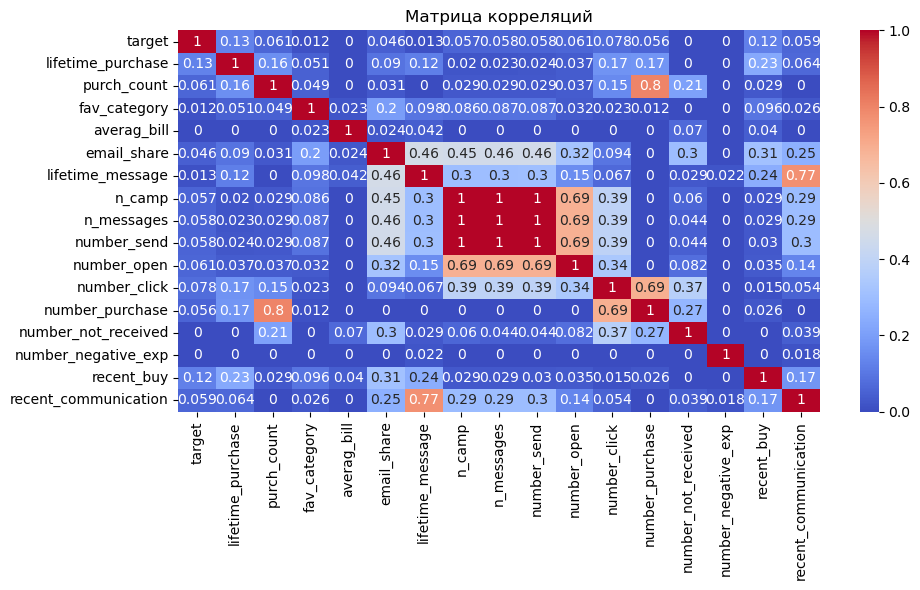

In [38]:
phik = df

plt.figure(figsize = (10,6))


sns.heatmap(phik.phik_matrix(interval_cols=['target', 'lifetime_purchase', 'purch_count',
       'averag_bill', 'email_share', 'lifetime_message',
       'n_camp', 'number_send','number_received','n_messages',  'number_open', 'number_click',
       'number_purchase',  'number_negative_exp','recent_buy','recent_communication'
        ]),
            annot = True,cmap='coolwarm')
plt.title('Матрица корреляций')

plt.tight_layout()
plt.show()

Заметим, что между переменными n_camp, n_messages, number_send ниблюдается сильная корреляция. Для избежания мультиколлинеарности удалим переменные n_camp, number_send.  
Кроме того, сильная кеорреляция между переменными purch_count и number_purchase - удалим number_purchase.  

Кроме этого, удалим переменные, которые имеют крайне низкую корреляцию с целевой переменной: number_not_receive, average_bill, number_negative_exp, fav_category,lifetime_message.

In [39]:
df = df.drop(['number_send','n_camp','number_negative_exp', 'averag_bill','number_not_received', 'number_purchase','fav_category','lifetime_message'],axis=1) 

In [40]:
df.describe()

,target,lifetime_purchase,purch_count,email_share,n_messages,number_open,number_click,recent_buy,recent_communication
count,41982.000000,41982.000000,41982.000000,41982.000000,41982.000000,41982.000000,41982.000000,41982.000000,41982.000000
mean,0.020151,23.767781,3.962055,0.497012,188.226478,59.774284,10.852318,0.108666,0.896551
std,0.140520,80.378258,5.304322,0.395789,104.672625,74.922798,14.164661,0.311223,0.304548
min,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,1.000000,0.060406,115.000000,4.000000,3.000000,0.000000,1.000000
50%,0.000000,1.000000,2.000000,0.448237,175.000000,26.000000,6.000000,0.000000,1.000000
75%,0.000000,1.000000,4.000000,1.000000,260.000000,94.000000,14.000000,0.000000,1.000000
max,1.000000,637.000000,218.000000,1.000000,2473.000000,1270.000000,384.000000,1.000000,1.000000


Заметим, что максимумы в переменных lifetime_purchase, purch_count,n_messages, number_open, number_click максимальные значения сильно отличаются от средних и 75% персентилей, взглянем на распределения подробнее.

Рассмотирм матрицу коллеряций еще раз:

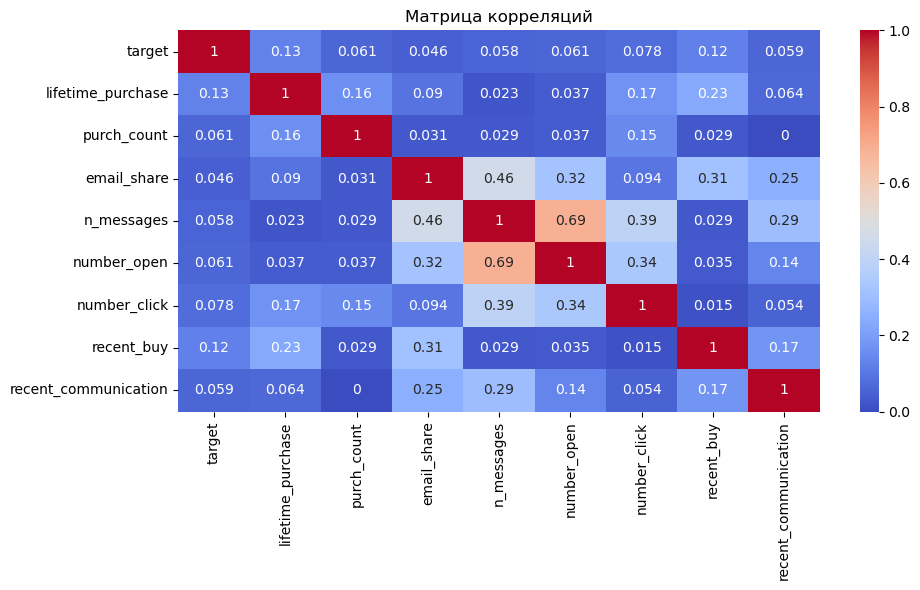

In [41]:
phik = df

plt.figure(figsize = (10,6))


sns.heatmap(phik.phik_matrix(interval_cols=['target', 'lifetime_purchase', 'purch_count',
       'email_share', 'lifetime_message',
       'averag_bill','n_messages',  'number_open', 'number_click',
       'recent_buy','recent_communication','number_negative_exp'
        ]),
            annot = True,cmap='coolwarm')
plt.title('Матрица корреляций')

plt.tight_layout()
plt.show()

Корреляционная таблица показывает отсутствие проблем (мультиколлинеарности). Корреляция с целевым признаком не велика, дальше необходимо перейти к построению модели машинного обучения.

## Построение модели классификации клиентов

### Обучение оптимальной модели

Для построения модели классификации будем использовать пайплайн для подбора оптимальных гиперпараметрво модели.

In [42]:
num_columns = ['lifetime_purchase', 'purch_count','email_share',
               'n_messages','number_open', 'number_click', 'recent_buy', 'recent_communication']

In [43]:
data_preprocessor = ColumnTransformer(
    transformers= [
       ('num', StandardScaler(), num_columns)
    ], 
    remainder='passthrough'
) 

In [44]:
RANDOM_STATE = 142

pipe_final = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', LogisticRegression(random_state=RANDOM_STATE))
    ]
)

In [45]:
param_distributions = [
    {
        'models': [LogisticRegression(random_state=RANDOM_STATE, solver = 'saga',penalty = 'elasticnet', max_iter = 100, class_weight = 'balanced')],
        'models__class_weight':['balanced'],
        'models__l1_ratio':[0,0.25,0.5,0.75,1],      
        'models__C':np.linspace(0.1,10,10),
        'preprocessor__num': [StandardScaler()]  
    },

    {
        'models': [CatBoostClassifier(auto_class_weights = 'Balanced',verbose=0,random_state=RANDOM_STATE)],
        'models__n_estimators': range(25, 40),
        'models__depth': range(4, 10),
        'models__learning_rate':[0.05,0.1,0.2],
        'preprocessor__num': ['passthrough']  
    }
] 

In [46]:
%%time

RANDOM_STATE = 142

X_train, X_test, y_train, y_test = train_test_split(
    df.drop(['target'],axis=1),
    df['target'],
    test_size = 0.2,
    stratify=phik['target'],
    random_state = RANDOM_STATE)


# Зададим отдельынй вид кросс-валидации
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

grid_search = GridSearchCV(
    pipe_final, 
    param_grid=param_distributions, 
    scoring = 'roc_auc' ,
    cv = cv, 
    n_jobs=-1,
    verbose = 2
)

grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 320 candidates, totalling 1600 fits
CPU times: user 2.81 s, sys: 931 ms, total: 3.74 s
Wall time: 2min 55s


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=142, shuffle=True),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['lifetime_purchase',
                                                                          'purch_count',
                                                                          'email_share',
                                                                          'n_messages',
                                                                          'number_open',
                                                                          'number_click',
                                                                          'recent_buy',
                                                                          'recent_communication'])])),
                                       ('models',
                                        LogisticRegr...
                          'models__class_weight': ['balanced'],
                          'models__l1_ratio': [0, 0.25, 0.5, 0.75, 1],
                          'preprocessor__num': [StandardScaler()]},
                         {'models': [<catboost.core.CatBoostClassifier object at 0x7efec75f7160>],
                          'models__depth': range(4, 10),
                          'models__learning_rate': [0.05, 0.1, 0.2],
                          'models__n_estimators': range(25, 40),
                          'preprocessor__num': ['passthrough']}],
             scoring='roc_auc', verbose=2)

In [47]:
grid_search.best_score_

0.7447486108349846

In [48]:
grid_search.best_params_

{'models': <catboost.core.CatBoostClassifier at 0x7efec75f7160>,
 'models__depth': 4,
 'models__learning_rate': 0.1,
 'models__n_estimators': 37,
 'preprocessor__num': 'passthrough'}

In [49]:
pd.DataFrame(grid_search.cv_results_).sort_values(by = 'rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_models,param_models__C,param_models__class_weight,param_models__l1_ratio,param_preprocessor__num,param_models__depth,...,param_models__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
77,0.625711,0.188829,0.010817,0.001407,<catboost.core.CatBoostClassifier object at 0x...,NaN,NaN,NaN,passthrough,4.0,...,37.0,{'models': <catboost.core.CatBoostClassifier o...,0.709783,0.714156,0.752079,0.781770,0.765955,0.744749,0.028399,1
79,0.467971,0.026973,0.008374,0.000527,<catboost.core.CatBoostClassifier object at 0x...,NaN,NaN,NaN,passthrough,4.0,...,39.0,{'models': <catboost.core.CatBoostClassifier o...,0.709626,0.714284,0.750902,0.781974,0.766824,0.744722,0.028540,2
78,0.610600,0.178250,0.009072,0.000946,<catboost.core.CatBoostClassifier object at 0x...,NaN,NaN,NaN,passthrough,4.0,...,38.0,{'models': <catboost.core.CatBoostClassifier o...,0.709780,0.713532,0.751948,0.781970,0.765926,0.744631,0.028576,3
76,0.401582,0.052307,0.008263,0.000238,<catboost.core.CatBoostClassifier object at 0x...,NaN,NaN,NaN,passthrough,4.0,...,36.0,{'models': <catboost.core.CatBoostClassifier o...,0.709731,0.713105,0.751273,0.781510,0.765452,0.744214,0.028456,4
75,0.346860,0.009370,0.008593,0.000527,<catboost.core.CatBoostClassifier object at 0x...,NaN,NaN,NaN,passthrough,4.0,...,35.0,{'models': <catboost.core.CatBoostClassifier o...,0.709161,0.713414,0.751991,0.780633,0.765215,0.744083,0.028302,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
315,1.105043,0.130443,0.019196,0.017541,<catboost.core.CatBoostClassifier object at 0x...,NaN,NaN,NaN,passthrough,9.0,...,35.0,{'models': <catboost.core.CatBoostClassifier o...,0.677976,0.689315,0.726791,0.736316,0.731201,0.712320,0.023877,316
316,1.120450,0.152917,0.009863,0.000674,<catboost.core.CatBoostClassifier object at 0x...,NaN,NaN,NaN,passthrough,9.0,...,36.0,{'models': <catboost.core.CatBoostClassifier o...,0.677100,0.690568,0.726882,0.736112,0.729973,0.712127,0.023678,317
317,1.020326,0.194753,0.010584,0.001700,<catboost.core.CatBoostClassifier object at 0x...,NaN,NaN,NaN,passthrough,9.0,...,37.0,{'models': <catboost.core.CatBoostClassifier o...,0.675482,0.688299,0.726027,0.731445,0.728872,0.710025,0.023389,318
318,1.025922,0.104251,0.009810,0.001218,<catboost.core.CatBoostClassifier object at 0x...,NaN,NaN,NaN,passthrough,9.0,...,38.0,{'models': <catboost.core.CatBoostClassifier o...,0.674899,0.688362,0.725670,0.730641,0.728787,0.709672,0.023342,319


Обучили оптимальную модель градиентного бустинга catboost со значением метрики ROC-AUC на кросс-валидации ~0.745. Модель имеет параметры: depth 4, learnin_rate 0.1, n_estimators 37.

### Тестирование модели на тестовой выборке и анализ важности признаков

In [50]:
preds = grid_search.predict_proba(X_test)

# вычислите метрику ROC-AUC и выведите её на экран командой print()
roc_auc = roc_auc_score(y_test, preds[:,1])
roc_auc

0.7376396228206183

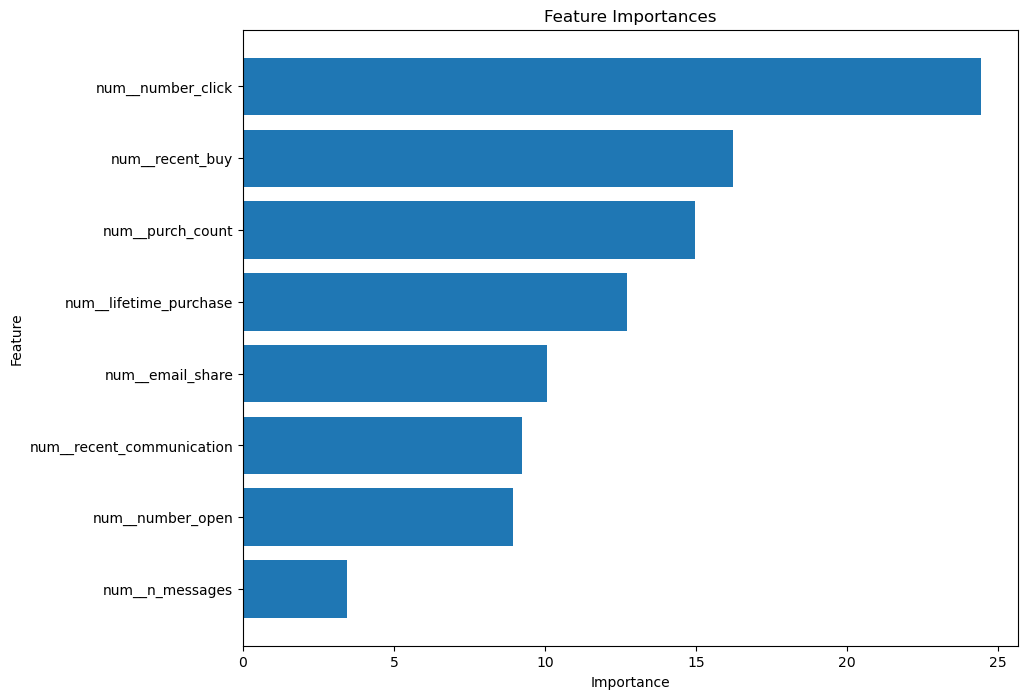

In [51]:
feature_importances = grid_search.best_estimator_.named_steps['models'].get_feature_importance()
feature_names = grid_search.best_estimator_.named_steps['preprocessor'].get_feature_names_out()

importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
})

importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Построение графика
plt.figure(figsize=(10, 8))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances')
plt.gca().invert_yaxis()  # Переворачиваем ось Y, чтобы наиболее важные признаки были наверху
plt.show()

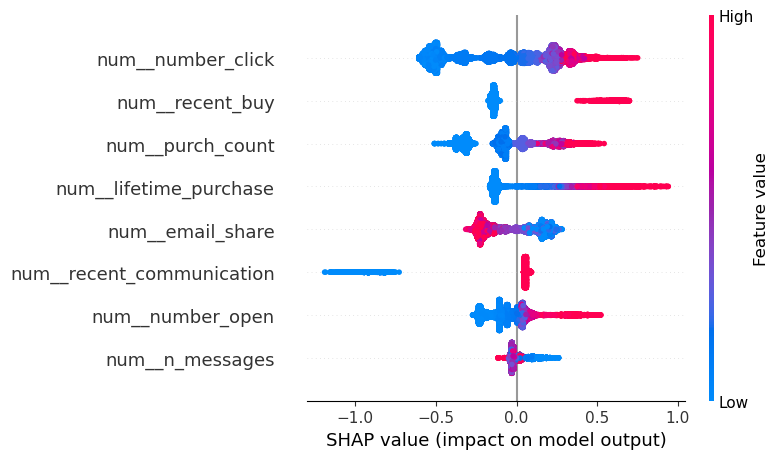

In [52]:
# Оценим направленность влияния признаков на целевую переменную
explainer = shap.TreeExplainer(grid_search.best_estimator_.named_steps['models'])

shap_values = explainer.shap_values(grid_search.best_estimator_.named_steps['preprocessor'].transform(X_train))

shap.summary_plot(shap_values, grid_search.best_estimator_.named_steps['preprocessor'].transform(X_train), feature_names=grid_search.best_estimator_.named_steps['preprocessor'].get_feature_names_out() )


На тестовой выборке модель также показала высокое значение метрики ROC-AUC 0.738.

Самым значимым фактором является количество переходов по ссылке из сообщения (также фактор открытия сообщений также оказывает положительное влияние на целевую переменную).  
Кроме этого, группа переменных описывающих прошлый покупательский опыт (кол-во покупок, длительность покупок, были ли покупки за последние 90 дней) имеют сильно влияние. Чем больше покупательский опыт клиента, тем с большей вероятностью он будет отнесен к классу 1 (сделает покупку в ближайшие 90 дней).  
Использование имейла как основного канала коммуникации с клиентом,а также отсутствие коммуникации в последние 90 дней, снижает вероятность будущих покупок.  
Наконец, слишком большой кол-во сообщений в целом также слегка снижает вероятность будущих покупок.

## Общий вывод

В рамках данного проекта мы проанализировали данные о покупках и маркетинговых коммуникациях с клиентами. В результате, мы обучили модель машинного обучения, которая определяет, совершит ли клиент покупку в течение ближайших 90 дней или нет. 

На входе мы получили разрозненные данные из разных источниках на различных уровнях агрегации. В ходе проекта мы провели обработку и исследовательский анализ данных, провели агрегацию на уровень пользователя, а также выделили потенциально значимые характеристики, влияющие на значение целевой переменной.  

Отдельно стоит отметить несколько моментов, связанных с данными:
1. Обучающая выборка крайне несбалансированна, из ~50 тысяч клиентов только ~1 тысяча клиентов имеет значение целевого признака равное 1.
2. Порядка 20% выборки клиентов не имеют записей в наборе данных с маркетинговыми сообщениями. Это явное упущение модели сбора данных о клиентах, для более качественного анализа необходимо большая полнота данных.
3. Данные в наборе сообщений с маркетинговыми сообщениями бывают противоречивы (событие purchase случается раньше события open  т.д.). Необходимо уделять больше внимания качеству данных.

Для построения модели машинного обучения мы использовали пайплайн с подбором гиперпараметров из широкого набора допустимых значений. Оценивались как простые модели (логистическая регрессия), так и более сложные (градиентные бустинги).  
В результате кросс-валидации мы обучили оптимальную модель - модель градиентного бустинга (catboos) с n_estimators 37, learning rete 0.1 и depth 4. Для нивелирования эффекта несбалансированного классов использовался параметр модели auto_class_weights = 'Balanced', придающим больший вес при ошибке на объектах с целевым признаком 1.

В качестве основной метрики заказчик указал ROC-AUC. Оптимальная модель показала среднее значение метрики 0.745 на кросс-валидации, а также высокое значение 0.738 на тестовой выборке (что выше порогового значения 0.7).

На основании оптимальной модели можно сделать ряд выводов о влиянии признаков на целевую переменную:
1. Клиенты, имеющие богатый опыт взаимодействия с магазином (совершают покупки долгое время, совершили уже много покупок, мовершали покупки в последние 90 дней) в среднем более склонны к тому, чтобы совершать покупки и в будущем.
2. Клиенты, с которыми общаются через mobile push уведомления более склонны к совершению новых покупок.
3. Хотя большое общее количество маркетинговых сообщений оказывает слегка негативное влияние на вероятность покупки, отдельно взятые шаги воронки "открытие сообщения" и "переход по ссылке" оказывают положительный эффект.
4. Клиенты, с которыми не проводилось маркетинговой коммуникации за последние 90 дней, вероятно не совершат покупку в ближайшем будущем.

Обощив, складывается впечатление, что у заказчика очень качественная платформа и в целом клиенты испытывают положительный опыт от взаимодействия с площадкой - те кто попробовали покупать, вероятно будути покупать и в будущем.
С точки зрения бизнес рекомендаций, мы считаем, что заказчику необходимо:
1. Сфокусироваться на существующих покупателях - они склонны к повторным покупкам.
2. Необходимо работать над контентом сообщений - переход из открытого сообщения по ссылке в среднем сильно повышает вероятность покупок в будущем. Качественный контент (открытие сообщения и переход по ссылке) гораздо важнее количества сообщений.
3.  Мобильные пуш уведомления являются более эффективным каналом коммуникации, стоит сосредоточиться на них
4.  Продолжать делать маркетинговую расслыку всем клиентам (ее отсутствие снижает шансы того, что покупки будут продолжаться)